In [1]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime

### 통합데이터 read

In [2]:
df = pd.read_csv(r'C:\Users\user\boyu571_github\01_Kakaobank_SKKU_Research_23\eng_raw_content_full.csv', index_col=0)
df

,Unnamed: 0.1,source,author,title,description,url,urlToImage,publishedAt,content,press,content_full
0,90,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Why you received so many gambling texts on Mel...,Did you get a rogue spammy text from a betting...,http://www.abc.net.au/triplej/programs/hack/wh...,http://www.abc.net.au/cm/rimage/9138232-1x1-la...,2017-11-10T02:54:30Z,Received a rogue spammy text from a betting co...,ABC News (AU),Received a rogue spammy text from a betting co...
1,740,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Big movements in value of Bitcoin,The local share market was dragged down by two...,http://www.abc.net.au/news/2017-11-13/big-move...,http://www.abc.net.au/news/image/9146426-1x1-7...,2017-11-13T08:41:19Z,"Posted November 13, 2017 19:41:19 The local sh...",ABC News (AU),The local share market was dragged down by two...
2,982,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,What's behind the jumps and bumps in Bitcoin's...,"The price of Bitcoin has dropped to around $8,...",http://www.abc.net.au/news/2017-11-14/bitcoin-...,http://www.abc.net.au/news/image/8944484-1x1-7...,2017-11-13T19:33:13Z,"Posted November 14, 2017 06:33:13 The price of...",ABC News (AU),"The price of Bitcoin has dropped to around $8,..."
3,1729,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",Amy McCosker,How blockchain could solve the issue of food f...,Blockchains and cryptocurrencies are no longer...,http://www.abc.net.au/news/rural/2017-11-16/ag...,http://www.abc.net.au/cm/rimage/8529260-16x9-l...,2017-11-15T19:28:47Z,Blockchains and cryptocurrencies are no longer...,ABC News (AU),Blockchains and cryptocurrencies are no longer...
4,1778,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Large bitcoin reward for missing world-record ...,"Two world-record winning cats are missing, and...",http://www.abc.net.au/news/2017-11-16/record-w...,http://www.abc.net.au/news/image/9155978-1x1-7...,2017-11-15T22:53:26Z,"Posted November 16, 2017 09:53:26 Two world-re...",ABC News (AU),"Two world-record winning cats are missing, and..."
...,...,...,...,...,...,...,...,...,...,...,...
3273,743605,"{'id': None, 'name': 'ZyCrypto'}",Brenda Ngari,Crypto Exchange Kraken Enters TradFi; To Offer...,Cryptocurrency exchange Kraken intends to expa...,https://zycrypto.com/crypto-exchange-kraken-en...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-28T19:31:40Z,Cryptocurrency exchange Kraken intends to expa...,ZyCrypto,\n\n\nAdvertisement\n\n\n\n\n \r\n\r\n \nCrypt...
3274,743610,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,"BTC Price Pushes Above $27,000 As Bitcoin Whal...","After starting the week on a positive note, Bi...",https://zycrypto.com/btc-price-pushes-above-27...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-28T19:55:09Z,"After starting the week on a positive note, Bi...",ZyCrypto,\n\n\nAdvertisement\n\n\n\n\n \r\n\r\n \nAfter...
3275,744199,"{'id': None, 'name': 'ZyCrypto'}",Brenda Ngari,SEC Delays Decision On Four Spot Bitcoin ETF P...,The U.S. Securities and Exchange Commission pu...,https://zycrypto.com/sec-delays-decision-on-fo...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-29T21:00:14Z,The U.S. Securities and Exchange Commission pu...,ZyCrypto,\n\n\nAdvertisement\n\n\n\n\n \r\n\r\n \nThe U...
3276,744422,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,CFTC Charges Three Defi Projects for Illegal O...,The Commodity Futures Trading Commission (CFTC...,https://zycrypto.com/cftc-charges-three-defi-p...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-30T21:08:56Z,The Commodity Futures Trading Commission (CFTC...,ZyCrypto,\n\n\nAdvertisement\n\n\n\n\n \r\n\r\n \nThe C...


In [5]:
df['content_full'] = df['content_full'].fillna('')

# 'content_full' 열이 비어 있는 경우만 필터링하여 새로운 데이터프레임을 만듭니다.
df_content = df[df['content_full'] != '']

In [6]:
# 'publishedAt' 열을 datetime 객체로 변환
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

# 날짜 범위 지정
start_date = '2017-12-01'
end_date = '2023-08-28'

# 날짜 범위에 해당하는 행 필터링
filtered_df = df[(df['publishedAt'] >= start_date) & (df['publishedAt'] <= end_date)]

print(filtered_df)

      Unnamed: 0.1                                          source  \
11            8727  {'id': 'abc-news-au', 'name': 'ABC News (AU)'}   
12           11689  {'id': 'abc-news-au', 'name': 'ABC News (AU)'}   
13           12141  {'id': 'abc-news-au', 'name': 'ABC News (AU)'}   
14           12194  {'id': 'abc-news-au', 'name': 'ABC News (AU)'}   
15           13521  {'id': 'abc-news-au', 'name': 'ABC News (AU)'}   
...            ...                                             ...   
3125        727941                {'id': None, 'name': 'ZyCrypto'}   
3126        728116                {'id': None, 'name': 'ZyCrypto'}   
3127        728356                {'id': None, 'name': 'ZyCrypto'}   
3128        728377                {'id': None, 'name': 'ZyCrypto'}   
3129        728378                {'id': None, 'name': 'ZyCrypto'}   

                author                                              title  \
11                 NaN  Venezuela to launch oil-backed cryptocurrency ...   
12   

In [7]:
filtered_df[filtered_df['content_full'] != '']

,Unnamed: 0.1,source,author,title,description,url,urlToImage,publishedAt,content,press,content_full
11,8727,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Venezuela to launch oil-backed cryptocurrency ...,Venezuela's Nicolas Maduro says his country wi...,http://www.abc.net.au/news/2017-12-04/venezuel...,http://www.abc.net.au/news/image/8944484-1x1-7...,2017-12-04 00:02:12+00:00,"Posted December 04, 2017 11:02:12 Venezuelan P...",ABC News (AU),Venezuelan President Nicolas Maduro has said h...
12,11689,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",Ariel Bogle,What happens to your bitcoin when you die,The value of bitcoin scaled new heights in 201...,http://www.abc.net.au/news/science/2017-12-08/...,http://www.abc.net.au/cm/rimage/5127290-16x9-l...,2017-12-07 19:31:20+00:00,The value of bitcoin scaled new heights in 201...,ABC News (AU),The value of bitcoin scaled new heights in 201...
13,12141,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",David Chau,TGIF! But don't spend your bitcoin on beer,"Bitcoin surges to a record-high $22,842 becaus...",http://www.abc.net.au/news/2017-12-08/tgif-jus...,http://www.abc.net.au/news/image/9241938-16x9-...,2017-12-08 07:28:30+00:00,"Posted December 08, 2017 18:28:30 Bitcoin and ...",ABC News (AU),Bitcoin and Kim Kardashian have one thing in c...
14,12194,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,"Bitcoin down, shares up",There's been a pause in Bitcoin's breathtaking...,http://www.abc.net.au/news/2017-12-08/bitcoin-...,http://www.abc.net.au/news/image/9242438-16x9-...,2017-12-08 09:25:26+00:00,This service may include material from Agence ...,ABC News (AU),There's been a pause in Bitcoin's breathtaking...
15,13521,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",Ian Verrender,What the bitcoin bubble tells us about ourselves,"Many of those ""investing"" have no idea about t...",http://www.abc.net.au/news/2017-12-11/bitcoin-...,http://www.abc.net.au/news/image/8529260-16x9-...,2017-12-10 20:29:07+00:00,"Posted December 11, 2017 07:29:07 Richard Thal...",ABC News (AU),Richard Thaler does a good line in one-liners....
...,...,...,...,...,...,...,...,...,...,...,...
3125,727941,"{'id': None, 'name': 'ZyCrypto'}",Marco Tulio,Ripple’s XRP Whales Are Soaring Fast As Accumu...,The increased activity of these major XRP whal...,https://zycrypto.com/ripples-xrp-whales-are-so...,https://zycrypto.com/wp-content/uploads/2020/0...,2023-08-25 20:02:03+00:00,"The price of XRP, Ripple’s native cryptocurren...",ZyCrypto,\n\n\nAdvertisement\n\n\n\n\n \r\n\r\n \nThe p...
3126,728116,"{'id': None, 'name': 'ZyCrypto'}",Aliyu Pokima,Bitcoin’s Worst Week Since FTX’s Collapse – He...,Bitcoin (BTC) is roiling under the pressure of...,https://zycrypto.com/bitcoins-worst-week-since...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-08-26 13:12:08+00:00,Bitcoin (BTC) is roiling under the pressure of...,ZyCrypto,\n\n\nAdvertisement\n\n\n\n\n \r\n\r\n \nBitco...
3127,728356,"{'id': None, 'name': 'ZyCrypto'}",Brenda Ngari,Why XRP Holders’ Attorney Says Hinman and Clay...,Deaton argues that this protracted courtroom w...,https://zycrypto.com/why-xrp-holders-attorney-...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-08-27 18:16:31+00:00,Legal expert John E. Deaton has slammed the U....,ZyCrypto,\n\n\nAdvertisement\n\n\n\n\n \r\n\r\n \nLegal...
3128,728377,"{'id': None, 'name': 'ZyCrypto'}",Aaron Feuerstein,Galaxy Digital’s Mike Novogratz Weighs in on S...,Galaxy Digital CEO Michael Novogratz has long ...,https://zycrypto.com/galaxy-digitals-mike-novo...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-08-27 21:17:34+00:00,Galaxy Digital CEO Michael Novogratz has long ...,ZyCrypto,\n\n\nAdvertisement\n\n\n\n\n \r\n\r\n \nGalax...


In [4]:
df['content_full'] = df['content_full'].fillna('')

# 'content_full' 열이 비어 있는 경우만 필터링하여 새로운 데이터프레임을 만듭니다.
df_content = df[df['content_full'] != '']
df_content.drop(df_content.columns[0], axis=1, inplace=True)

df_content.reset_index()
df_content

c:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,source,author,title,description,url,urlToImage,publishedAt,content,press,content_full
0,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Why you received so many gambling texts on Mel...,Did you get a rogue spammy text from a betting...,http://www.abc.net.au/triplej/programs/hack/wh...,http://www.abc.net.au/cm/rimage/9138232-1x1-la...,2017-11-10T02:54:30Z,Received a rogue spammy text from a betting co...,ABC News (AU),Received a rogue spammy text from a betting co...
1,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Big movements in value of Bitcoin,The local share market was dragged down by two...,http://www.abc.net.au/news/2017-11-13/big-move...,http://www.abc.net.au/news/image/9146426-1x1-7...,2017-11-13T08:41:19Z,"Posted November 13, 2017 19:41:19 The local sh...",ABC News (AU),The local share market was dragged down by two...
2,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,What's behind the jumps and bumps in Bitcoin's...,"The price of Bitcoin has dropped to around $8,...",http://www.abc.net.au/news/2017-11-14/bitcoin-...,http://www.abc.net.au/news/image/8944484-1x1-7...,2017-11-13T19:33:13Z,"Posted November 14, 2017 06:33:13 The price of...",ABC News (AU),"The price of Bitcoin has dropped to around $8,..."
3,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",Amy McCosker,How blockchain could solve the issue of food f...,Blockchains and cryptocurrencies are no longer...,http://www.abc.net.au/news/rural/2017-11-16/ag...,http://www.abc.net.au/cm/rimage/8529260-16x9-l...,2017-11-15T19:28:47Z,Blockchains and cryptocurrencies are no longer...,ABC News (AU),Blockchains and cryptocurrencies are no longer...
4,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Large bitcoin reward for missing world-record ...,"Two world-record winning cats are missing, and...",http://www.abc.net.au/news/2017-11-16/record-w...,http://www.abc.net.au/news/image/9155978-1x1-7...,2017-11-15T22:53:26Z,"Posted November 16, 2017 09:53:26 Two world-re...",ABC News (AU),"Two world-record winning cats are missing, and..."
...,...,...,...,...,...,...,...,...,...,...
3273,"{'id': None, 'name': 'ZyCrypto'}",Brenda Ngari,Crypto Exchange Kraken Enters TradFi; To Offer...,Cryptocurrency exchange Kraken intends to expa...,https://zycrypto.com/crypto-exchange-kraken-en...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-28T19:31:40Z,Cryptocurrency exchange Kraken intends to expa...,ZyCrypto,\n\n\nAdvertisement\n\n\n\n\n \r\n\r\n \nCrypt...
3274,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,"BTC Price Pushes Above $27,000 As Bitcoin Whal...","After starting the week on a positive note, Bi...",https://zycrypto.com/btc-price-pushes-above-27...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-28T19:55:09Z,"After starting the week on a positive note, Bi...",ZyCrypto,\n\n\nAdvertisement\n\n\n\n\n \r\n\r\n \nAfter...
3275,"{'id': None, 'name': 'ZyCrypto'}",Brenda Ngari,SEC Delays Decision On Four Spot Bitcoin ETF P...,The U.S. Securities and Exchange Commission pu...,https://zycrypto.com/sec-delays-decision-on-fo...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-29T21:00:14Z,The U.S. Securities and Exchange Commission pu...,ZyCrypto,\n\n\nAdvertisement\n\n\n\n\n \r\n\r\n \nThe U...
3276,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,CFTC Charges Three Defi Projects for Illegal O...,The Commodity Futures Trading Commission (CFTC...,https://zycrypto.com/cftc-charges-three-defi-p...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-30T21:08:56Z,The Commodity Futures Trading Commission (CFTC...,ZyCrypto,\n\n\nAdvertisement\n\n\n\n\n \r\n\r\n \nThe C...


In [5]:
df_content['title'] = df_content['title'].str.replace('\n', '').str.replace('\t', '')
df_content['title'] = df_content['title'].str.replace('\r', '').str.replace("\'", "'")
df_content['content_full'] = df_content['content_full'].str.replace('\n', ' ').str.replace('\t', ' ')
df_content['content_full'] = df_content['content_full'].str.replace('\r', ' ').str.replace("\'", "'")
df_content

<ipython-input-5-274a2c476f14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content['title'] = df_content['title'].str.replace('\n', '').str.replace('\t', '')
<ipython-input-5-274a2c476f14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content['title'] = df_content['title'].str.replace('\r', '')
<ipython-input-5-274a2c476f14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

,source,author,title,description,url,urlToImage,publishedAt,content,press,content_full
0,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Why you received so many gambling texts on Mel...,Did you get a rogue spammy text from a betting...,http://www.abc.net.au/triplej/programs/hack/wh...,http://www.abc.net.au/cm/rimage/9138232-1x1-la...,2017-11-10T02:54:30Z,Received a rogue spammy text from a betting co...,ABC News (AU),Received a rogue spammy text from a betting co...
1,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Big movements in value of Bitcoin,The local share market was dragged down by two...,http://www.abc.net.au/news/2017-11-13/big-move...,http://www.abc.net.au/news/image/9146426-1x1-7...,2017-11-13T08:41:19Z,"Posted November 13, 2017 19:41:19 The local sh...",ABC News (AU),The local share market was dragged down by two...
2,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,What's behind the jumps and bumps in Bitcoin's...,"The price of Bitcoin has dropped to around $8,...",http://www.abc.net.au/news/2017-11-14/bitcoin-...,http://www.abc.net.au/news/image/8944484-1x1-7...,2017-11-13T19:33:13Z,"Posted November 14, 2017 06:33:13 The price of...",ABC News (AU),"The price of Bitcoin has dropped to around $8,..."
3,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",Amy McCosker,How blockchain could solve the issue of food f...,Blockchains and cryptocurrencies are no longer...,http://www.abc.net.au/news/rural/2017-11-16/ag...,http://www.abc.net.au/cm/rimage/8529260-16x9-l...,2017-11-15T19:28:47Z,Blockchains and cryptocurrencies are no longer...,ABC News (AU),Blockchains and cryptocurrencies are no longer...
4,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Large bitcoin reward for missing world-record ...,"Two world-record winning cats are missing, and...",http://www.abc.net.au/news/2017-11-16/record-w...,http://www.abc.net.au/news/image/9155978-1x1-7...,2017-11-15T22:53:26Z,"Posted November 16, 2017 09:53:26 Two world-re...",ABC News (AU),"Two world-record winning cats are missing, and..."
...,...,...,...,...,...,...,...,...,...,...
3273,"{'id': None, 'name': 'ZyCrypto'}",Brenda Ngari,Crypto Exchange Kraken Enters TradFi; To Offer...,Cryptocurrency exchange Kraken intends to expa...,https://zycrypto.com/crypto-exchange-kraken-en...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-28T19:31:40Z,Cryptocurrency exchange Kraken intends to expa...,ZyCrypto,Advertisement Cryptocurrency exc...
3274,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,"BTC Price Pushes Above $27,000 As Bitcoin Whal...","After starting the week on a positive note, Bi...",https://zycrypto.com/btc-price-pushes-above-27...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-28T19:55:09Z,"After starting the week on a positive note, Bi...",ZyCrypto,Advertisement After starting the...
3275,"{'id': None, 'name': 'ZyCrypto'}",Brenda Ngari,SEC Delays Decision On Four Spot Bitcoin ETF P...,The U.S. Securities and Exchange Commission pu...,https://zycrypto.com/sec-delays-decision-on-fo...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-29T21:00:14Z,The U.S. Securities and Exchange Commission pu...,ZyCrypto,Advertisement The U.S. Securitie...
3276,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,CFTC Charges Three Defi Projects for Illegal O...,The Commodity Futures Trading Commission (CFTC...,https://zycrypto.com/cftc-charges-three-defi-p...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-30T21:08:56Z,The Commodity Futures Trading Commission (CFTC...,ZyCrypto,Advertisement The Commodity Futu...


In [6]:
# 'content'열과 'description'열에서 각 행의 첫 10개 단어를 추출
def extract_first_10_words(text):
    # 단어 단위로 분할하여 첫 10개 단어를 반환
    words = text.split()[:10] if isinstance(text, str) else []
    return " ".join(words)

# 'content'열과 'description'열의 첫 10개 단어를 추출하여 새로운 열에 저장
df_content['first_10_words_content'] = df_content['content'].apply(extract_first_10_words)
df_content['first_10_words_description'] = df_content['description'].apply(extract_first_10_words)

# 추출된 단어 확인
df_content[['first_10_words_content', 'first_10_words_description']].head()

def find_and_trim_content(full_content, content_words, description_words):
    # 'content_full'에서 'content'와 'description' 단어의 위치를 찾기
    content_index = full_content.find(content_words)
    description_index = full_content.find(description_words)

    # 둘 중 하나만 존재하는 경우, 존재하는 단어부터의 문자열을 반환
    if content_index != -1 and description_index == -1:
        return full_content[content_index:]
    elif content_index == -1 and description_index != -1:
        return full_content[description_index:]
    # 둘 다 존재하는 경우, 더 앞쪽에 있는 단어를 기준으로 반환
    elif content_index != -1 and description_index != -1:
        return full_content[min(content_index, description_index):]
    # 둘 다 없는 경우, 원본 'content_full'을 반환
    else:
        return full_content



<ipython-input-6-9cf452c21342>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content['first_10_words_content'] = df_content['content'].apply(extract_first_10_words)
<ipython-input-6-9cf452c21342>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content['first_10_words_description'] = df_content['description'].apply(extract_first_10_words)


In [7]:
# 'content_full'을 조건에 따라 잘라내기
df_content['trimmed_content'] = df_content.apply(
    lambda row: find_and_trim_content(row['content_full'], 
                                      row['first_10_words_content'], 
                                      row['first_10_words_description']), axis=1)

# 불필요한 열을 제거하고 'trimmed_content'를 'content_full'로 이름 변경
df_content = df_content.drop(columns=['first_10_words_content', 'first_10_words_description', 'content_full'])
df_content.rename(columns={'trimmed_content': 'content_full', 'publishedAt': 'time'}, inplace=True)

# 결과 확인
df_content


<ipython-input-7-1dbc0e761327>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content['trimmed_content'] = df_content.apply(


,source,author,title,description,url,urlToImage,time,content,press,content_full
0,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Why you received so many gambling texts on Mel...,Did you get a rogue spammy text from a betting...,http://www.abc.net.au/triplej/programs/hack/wh...,http://www.abc.net.au/cm/rimage/9138232-1x1-la...,2017-11-10T02:54:30Z,Received a rogue spammy text from a betting co...,ABC News (AU),Received a rogue spammy text from a betting co...
1,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Big movements in value of Bitcoin,The local share market was dragged down by two...,http://www.abc.net.au/news/2017-11-13/big-move...,http://www.abc.net.au/news/image/9146426-1x1-7...,2017-11-13T08:41:19Z,"Posted November 13, 2017 19:41:19 The local sh...",ABC News (AU),The local share market was dragged down by two...
2,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,What's behind the jumps and bumps in Bitcoin's...,"The price of Bitcoin has dropped to around $8,...",http://www.abc.net.au/news/2017-11-14/bitcoin-...,http://www.abc.net.au/news/image/8944484-1x1-7...,2017-11-13T19:33:13Z,"Posted November 14, 2017 06:33:13 The price of...",ABC News (AU),"The price of Bitcoin has dropped to around $8,..."
3,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",Amy McCosker,How blockchain could solve the issue of food f...,Blockchains and cryptocurrencies are no longer...,http://www.abc.net.au/news/rural/2017-11-16/ag...,http://www.abc.net.au/cm/rimage/8529260-16x9-l...,2017-11-15T19:28:47Z,Blockchains and cryptocurrencies are no longer...,ABC News (AU),Blockchains and cryptocurrencies are no longer...
4,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Large bitcoin reward for missing world-record ...,"Two world-record winning cats are missing, and...",http://www.abc.net.au/news/2017-11-16/record-w...,http://www.abc.net.au/news/image/9155978-1x1-7...,2017-11-15T22:53:26Z,"Posted November 16, 2017 09:53:26 Two world-re...",ABC News (AU),"Two world-record winning cats are missing, and..."
...,...,...,...,...,...,...,...,...,...,...
3273,"{'id': None, 'name': 'ZyCrypto'}",Brenda Ngari,Crypto Exchange Kraken Enters TradFi; To Offer...,Cryptocurrency exchange Kraken intends to expa...,https://zycrypto.com/crypto-exchange-kraken-en...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-28T19:31:40Z,Cryptocurrency exchange Kraken intends to expa...,ZyCrypto,Cryptocurrency exchange Kraken intends to expa...
3274,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,"BTC Price Pushes Above $27,000 As Bitcoin Whal...","After starting the week on a positive note, Bi...",https://zycrypto.com/btc-price-pushes-above-27...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-28T19:55:09Z,"After starting the week on a positive note, Bi...",ZyCrypto,"After starting the week on a positive note, Bi..."
3275,"{'id': None, 'name': 'ZyCrypto'}",Brenda Ngari,SEC Delays Decision On Four Spot Bitcoin ETF P...,The U.S. Securities and Exchange Commission pu...,https://zycrypto.com/sec-delays-decision-on-fo...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-29T21:00:14Z,The U.S. Securities and Exchange Commission pu...,ZyCrypto,The U.S. Securities and Exchange Commission pu...
3276,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,CFTC Charges Three Defi Projects for Illegal O...,The Commodity Futures Trading Commission (CFTC...,https://zycrypto.com/cftc-charges-three-defi-p...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-30T21:08:56Z,The Commodity Futures Trading Commission (CFTC...,ZyCrypto,The Commodity Futures Trading Commission (CFTC...


In [8]:
# `title`이 동일한 경우 중복 행 삭제
df_content = df_content.drop_duplicates(subset='title')

# `content`가 동일한 경우 중복 행 삭제
df_content = df_content.drop_duplicates(subset='content')
df_content = df_content.drop_duplicates(subset='description')
df_content

,source,author,title,description,url,urlToImage,time,content,press,content_full
0,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Why you received so many gambling texts on Mel...,Did you get a rogue spammy text from a betting...,http://www.abc.net.au/triplej/programs/hack/wh...,http://www.abc.net.au/cm/rimage/9138232-1x1-la...,2017-11-10T02:54:30Z,Received a rogue spammy text from a betting co...,ABC News (AU),Received a rogue spammy text from a betting co...
1,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Big movements in value of Bitcoin,The local share market was dragged down by two...,http://www.abc.net.au/news/2017-11-13/big-move...,http://www.abc.net.au/news/image/9146426-1x1-7...,2017-11-13T08:41:19Z,"Posted November 13, 2017 19:41:19 The local sh...",ABC News (AU),The local share market was dragged down by two...
2,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,What's behind the jumps and bumps in Bitcoin's...,"The price of Bitcoin has dropped to around $8,...",http://www.abc.net.au/news/2017-11-14/bitcoin-...,http://www.abc.net.au/news/image/8944484-1x1-7...,2017-11-13T19:33:13Z,"Posted November 14, 2017 06:33:13 The price of...",ABC News (AU),"The price of Bitcoin has dropped to around $8,..."
3,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",Amy McCosker,How blockchain could solve the issue of food f...,Blockchains and cryptocurrencies are no longer...,http://www.abc.net.au/news/rural/2017-11-16/ag...,http://www.abc.net.au/cm/rimage/8529260-16x9-l...,2017-11-15T19:28:47Z,Blockchains and cryptocurrencies are no longer...,ABC News (AU),Blockchains and cryptocurrencies are no longer...
4,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Large bitcoin reward for missing world-record ...,"Two world-record winning cats are missing, and...",http://www.abc.net.au/news/2017-11-16/record-w...,http://www.abc.net.au/news/image/9155978-1x1-7...,2017-11-15T22:53:26Z,"Posted November 16, 2017 09:53:26 Two world-re...",ABC News (AU),"Two world-record winning cats are missing, and..."
...,...,...,...,...,...,...,...,...,...,...
3273,"{'id': None, 'name': 'ZyCrypto'}",Brenda Ngari,Crypto Exchange Kraken Enters TradFi; To Offer...,Cryptocurrency exchange Kraken intends to expa...,https://zycrypto.com/crypto-exchange-kraken-en...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-28T19:31:40Z,Cryptocurrency exchange Kraken intends to expa...,ZyCrypto,Cryptocurrency exchange Kraken intends to expa...
3274,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,"BTC Price Pushes Above $27,000 As Bitcoin Whal...","After starting the week on a positive note, Bi...",https://zycrypto.com/btc-price-pushes-above-27...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-28T19:55:09Z,"After starting the week on a positive note, Bi...",ZyCrypto,"After starting the week on a positive note, Bi..."
3275,"{'id': None, 'name': 'ZyCrypto'}",Brenda Ngari,SEC Delays Decision On Four Spot Bitcoin ETF P...,The U.S. Securities and Exchange Commission pu...,https://zycrypto.com/sec-delays-decision-on-fo...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-29T21:00:14Z,The U.S. Securities and Exchange Commission pu...,ZyCrypto,The U.S. Securities and Exchange Commission pu...
3276,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,CFTC Charges Three Defi Projects for Illegal O...,The Commodity Futures Trading Commission (CFTC...,https://zycrypto.com/cftc-charges-three-defi-p...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-30T21:08:56Z,The Commodity Futures Trading Commission (CFTC...,ZyCrypto,The Commodity Futures Trading Commission (CFTC...


In [9]:
# df_content = df_content.sort_values('time').reset_index(drop=True)
df_content['time'] = pd.to_datetime(df_content['time'])
df_content['date'] = df_content['time'].dt.date
df_content

,source,author,title,description,url,urlToImage,time,content,press,content_full,date
0,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Why you received so many gambling texts on Mel...,Did you get a rogue spammy text from a betting...,http://www.abc.net.au/triplej/programs/hack/wh...,http://www.abc.net.au/cm/rimage/9138232-1x1-la...,2017-11-10 02:54:30+00:00,Received a rogue spammy text from a betting co...,ABC News (AU),Received a rogue spammy text from a betting co...,2017-11-10
1,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Big movements in value of Bitcoin,The local share market was dragged down by two...,http://www.abc.net.au/news/2017-11-13/big-move...,http://www.abc.net.au/news/image/9146426-1x1-7...,2017-11-13 08:41:19+00:00,"Posted November 13, 2017 19:41:19 The local sh...",ABC News (AU),The local share market was dragged down by two...,2017-11-13
2,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,What's behind the jumps and bumps in Bitcoin's...,"The price of Bitcoin has dropped to around $8,...",http://www.abc.net.au/news/2017-11-14/bitcoin-...,http://www.abc.net.au/news/image/8944484-1x1-7...,2017-11-13 19:33:13+00:00,"Posted November 14, 2017 06:33:13 The price of...",ABC News (AU),"The price of Bitcoin has dropped to around $8,...",2017-11-13
3,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",Amy McCosker,How blockchain could solve the issue of food f...,Blockchains and cryptocurrencies are no longer...,http://www.abc.net.au/news/rural/2017-11-16/ag...,http://www.abc.net.au/cm/rimage/8529260-16x9-l...,2017-11-15 19:28:47+00:00,Blockchains and cryptocurrencies are no longer...,ABC News (AU),Blockchains and cryptocurrencies are no longer...,2017-11-15
4,"{'id': 'abc-news-au', 'name': 'ABC News (AU)'}",NaN,Large bitcoin reward for missing world-record ...,"Two world-record winning cats are missing, and...",http://www.abc.net.au/news/2017-11-16/record-w...,http://www.abc.net.au/news/image/9155978-1x1-7...,2017-11-15 22:53:26+00:00,"Posted November 16, 2017 09:53:26 Two world-re...",ABC News (AU),"Two world-record winning cats are missing, and...",2017-11-15
...,...,...,...,...,...,...,...,...,...,...,...
3273,"{'id': None, 'name': 'ZyCrypto'}",Brenda Ngari,Crypto Exchange Kraken Enters TradFi; To Offer...,Cryptocurrency exchange Kraken intends to expa...,https://zycrypto.com/crypto-exchange-kraken-en...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-28 19:31:40+00:00,Cryptocurrency exchange Kraken intends to expa...,ZyCrypto,Cryptocurrency exchange Kraken intends to expa...,2023-09-28
3274,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,"BTC Price Pushes Above $27,000 As Bitcoin Whal...","After starting the week on a positive note, Bi...",https://zycrypto.com/btc-price-pushes-above-27...,https://zycrypto.com/wp-content/uploads/2023/0...,2023-09-28 19:55:09+00:00,"After starting the week on a positive note, Bi...",ZyCrypto,"After starting the week on a positive note, Bi...",2023-09-28
3275,"{'id': None, 'name': 'ZyCrypto'}",Brenda Ngari,SEC Delays Decision On Four Spot Bitcoin ETF P...,The U.S. Securities and Exchange Commission pu...,https://zycrypto.com/sec-delays-decision-on-fo...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-29 21:00:14+00:00,The U.S. Securities and Exchange Commission pu...,ZyCrypto,The U.S. Securities and Exchange Commission pu...,2023-09-29
3276,"{'id': None, 'name': 'ZyCrypto'}",Newton Gitonga,CFTC Charges Three Defi Projects for Illegal O...,The Commodity Futures Trading Commission (CFTC...,https://zycrypto.com/cftc-charges-three-defi-p...,https://zycrypto.com/wp-content/uploads/2021/1...,2023-09-30 21:08:56+00:00,The Commodity Futures Trading Commission (CFTC...,ZyCrypto,The Commodity Futures Trading Commission (CFTC...,2023-09-30


In [10]:
df_content.to_csv('first_processed_eng_data.csv', encoding='utf-8-sig', index=False)

In [31]:
# 필터링된 결과를 날짜별로 그룹화하고 카운트
datewise_df = df_content.groupby('date').size()

# Filter dates where the count is exactly 10
# dates_with_exact_10 = datewise_counts_sample[(datewise_counts_sample >= 400) & (datewise_counts_sample <= 420)].index
datewise_df

date
2017-11-09     28
2017-11-10    134
2017-11-11     45
2017-11-12     38
2017-11-13    159
             ... 
2023-09-26    270
2023-09-27    270
2023-09-28    278
2023-09-29    231
2023-09-30     77
Length: 2152, dtype: int64

count    2152.000000
mean      158.822955
std        98.156252
min        17.000000
25%        84.000000
50%       125.000000
75%       243.000000
max       490.000000
dtype: float64


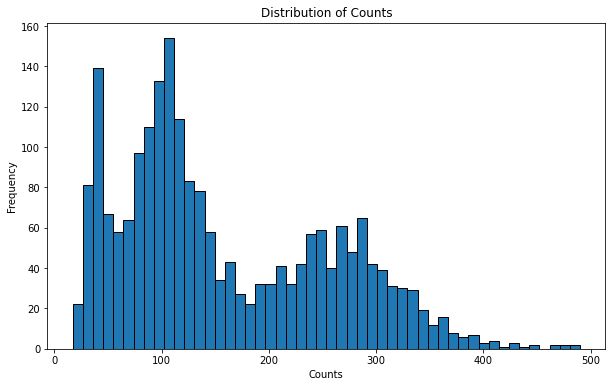

In [32]:
# 기본 통계 요약
print(datewise_df.describe())

# 히스토그램
plt.figure(figsize=(10, 6))
datewise_df.hist(bins=50, edgecolor='black')
plt.title("Distribution of Counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [64]:
# Create a date object for the date you want to filter
filter_date = datetime.strptime('2021-06-15', '%Y-%m-%d').date()

# Use this date object to filter the DataFrame
eng = df_content[df_content['date'] == filter_date]
len(eng)

250

In [65]:
eng.to_csv('eng_250.csv', index = False)

In [63]:
datewise_df[datewise_df == 250]

date
2018-02-20    250
2021-05-28    250
2021-06-15    250
2021-09-21    250
2021-11-12    250
2022-01-07    250
2022-02-28    250
2022-12-27    250
2023-02-17    250
2023-04-18    250
2023-05-04    250
2023-09-22    250
dtype: int64

In [44]:
df_content['date'][0]

datetime.date(2017, 11, 9)

In [43]:
eng_490 = df_content[df_content['date']== '2017-11-09']
eng_490

,source,author,title,description,url,urlToImage,time,content,press,content_full,date


In [9]:
def preprocess_and_vectorize(data):
    # 형태소 분석기 초기화
    okt = Okt()

    # 기사의 내용을 형태소로 분석
    tokenized_content = data['content'].apply(lambda x: ' '.join(okt.morphs(x)))

    # TF-IDF 변환
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(tokenized_content)
    
    return tfidf_matrix

In [11]:
def get_representative_indices(cosine_sim, threshold=0.6):
    visited = np.zeros(cosine_sim.shape[0], dtype=bool)
    representatives = []
    
    for i in range(cosine_sim.shape[0]):
        if not visited[i]:
            similar_articles = np.where(cosine_sim[i] > threshold)[0]
            if len(similar_articles) > 0:  # Check if there are any similar articles
                representatives.append(similar_articles[0])
                visited[similar_articles] = True
            
    return representatives

def filter_articles_within_group(group_df):
    # 데이터 전처리 및 벡터화
    tfidf_matrix = preprocess_and_vectorize(group_df)

    # 코사인 유사도 계산
    cosine_sim = cosine_similarity(tfidf_matrix)

    # 대표 기사 인덱스 추출
    representative_indices = get_representative_indices(cosine_sim)
    if len(representative_indices) == 0:  # Check if there are any representative articles
        return pd.DataFrame()  # Return an empty dataframe

    # 대표 기사만 포함된 데이터프레임 반환
    return group_df.iloc[representative_indices].reset_index(drop=True)

# 'UTC-date'를 기준으로 그룹화하고 각 그룹별로 중복 기사 필터링
filtered_groups = filtered_df.groupby('UTC-date').apply(filter_articles_within_group)

# 인덱스 재설정
filtered_df_final = filtered_groups.reset_index(drop=True)

In [12]:
filtered_df_final

,date,time,title,content,press,link,UTC-time,UTC-date
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,\n\n\n\n\n© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2016-12-31 22:00:00,2016-12-31
1,2017-01-01,2017-01-01 07:02:03,"2017년 주식 투자…IT, 인프라 ‘솔깃’ 해외주식도 담아보자",\n\t\t\t[헤럴드경제=김지헌 기자] 올해도 지루한 박스피(박스권에 갇힌 코스피...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2016-12-31 22:02:03,2016-12-31
2,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",\n【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다.\n ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,2017-01-01 06:15:04,2017-01-01
3,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",\n\t\t\t“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블...,39면 1단,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 07:03:04,2017-01-01
4,2017-01-01,2017-01-01 12:03:13,[2017 국제 핫이슈]블록체인 기술 확산,\n\t\t\t블록체인은 `제2의 인터넷` `넥스트 인터넷`으로 불린다. 새해에는 ...,전자신문,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 03:03:13,2017-01-01
...,...,...,...,...,...,...,...,...
161562,2023-08-30,2023-08-30 10:31:36,올해 상반기 금융사 '의심 거래' 보고 10% 늘어,\n\t\t\t올해 상반기 금융사들의 의심 거래 보고 건수가 지난해보다 10% 가까...,YTN,https://n.news.naver.com/mnews/article/052/000...,2023-08-30 01:31:36,2023-08-30
161563,2023-08-30,2023-08-30 09:12:12,훨훨 난 비트코인…현물 ETF 상장 호재에 6% 급등,"\n비트코인, 박스권 깨고 3700만원 돌파\n\n\n\n[서울=뉴시스]이지영 기자...",뉴시스언론사 선정,https://n.news.naver.com/mnews/article/003/001...,2023-08-30 00:12:12,2023-08-30
161564,2023-08-30,2023-08-30 09:41:23,"이원욱 ""이재명 1년, 미래도 유능함도 없는 민주당 돼""","\n이원욱 ""민주, 여전히 이재명의 대표리스크""""정치 훌리건의 공격 난무하는 친명 ...",뉴시스언론사 선정,https://n.news.naver.com/mnews/article/003/001...,2023-08-30 00:41:23,2023-08-30
161565,2023-08-30,2023-08-30 10:18:01,"업비트, “FDS로 250억 규모 보이스피싱 차단…이상거래 철통방어”",\n\n\n\n\n사진=업비트업비트가 자체 이상거래 탐지시스템(FDS)으로 사전 차...,14면 3단,https://n.news.naver.com/mnews/article/030/000...,2023-08-30 01:18:01,2023-08-30


In [13]:
print(len(filtered_df))
print(len(filtered_df_final))

259994
161567


In [17]:
filtered_df_final.to_csv('sim_del_naver_news_data.csv', encoding='utf-8-sig', index=False)

In [14]:
# 필터링된 결과를 날짜별로 그룹화하고 카운트
datewise_counts_non_empty = filtered_df_final.groupby('UTC-date').size()

datewise_counts_non_empty

UTC-date
2016-12-31     2
2017-01-01     5
2017-01-02    18
2017-01-03    24
2017-01-04    10
              ..
2023-08-26    10
2023-08-27    33
2023-08-28    51
2023-08-29    61
2023-08-30    15
Length: 2431, dtype: int64

count    2431.000000
mean       66.461127
std        61.295285
min         1.000000
25%        24.500000
50%        49.000000
75%        91.000000
max       464.000000
dtype: float64


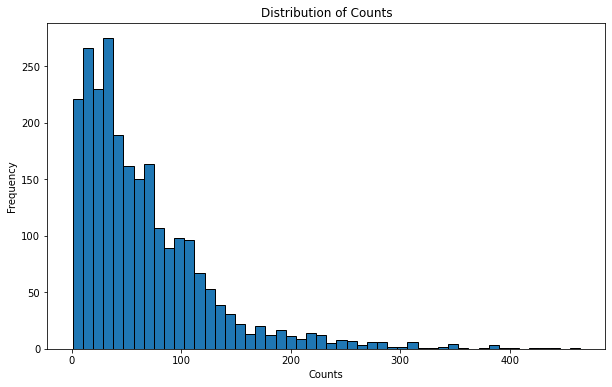

In [16]:
# 기본 통계 요약
print(datewise_counts_non_empty.describe())

# 히스토그램
plt.figure(figsize=(10, 6))
datewise_counts_non_empty.hist(bins=50, edgecolor='black')
plt.title("Distribution of Counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

In [26]:
data = filtered_df_final
data

,date,time,title,content,press,link,UTC-time,UTC-date
0,2017-01-01,2017-01-01 07:00:00,한국 금융산업 위기… ‘우버 모멘트’ 를 넘어라,\n\n\n\n\n© News1저금리·저성장 전통 금융산업 위기4차 산업혁명...세...,뉴스1,https://n.news.naver.com/mnews/article/421/000...,2016-12-31 22:00:00,2016-12-31
1,2017-01-01,2017-01-01 07:02:03,"2017년 주식 투자…IT, 인프라 ‘솔깃’ 해외주식도 담아보자",\n\t\t\t[헤럴드경제=김지헌 기자] 올해도 지루한 박스피(박스권에 갇힌 코스피...,헤럴드경제,https://n.news.naver.com/mnews/article/016/000...,2016-12-31 22:02:03,2016-12-31
2,2017-01-01,2017-01-01 15:15:04,"英 파운드, 2016년 최악의 통화 ···'디지털통화' 비트코인 최고의 수익자산...",\n【뉴욕=정지원 특파원】 영국의 파운드가 2106년 최악의 통화로 기록됐다.\n ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,2017-01-01 06:15:04,2017-01-01
3,2017-01-01,2017-01-01 16:03:04,"[신년기획]블록체인, 금융권 넘어 IT기업도 관심",\n\t\t\t“블록체인은 인터넷 이후 나온 가장 혁신적이며 파괴적인 기술이다.”블...,39면 1단,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 07:03:04,2017-01-01
4,2017-01-01,2017-01-01 12:03:13,[2017 국제 핫이슈]블록체인 기술 확산,\n\t\t\t블록체인은 `제2의 인터넷` `넥스트 인터넷`으로 불린다. 새해에는 ...,전자신문,https://n.news.naver.com/mnews/article/030/000...,2017-01-01 03:03:13,2017-01-01
...,...,...,...,...,...,...,...,...
161562,2023-08-30,2023-08-30 10:31:36,올해 상반기 금융사 '의심 거래' 보고 10% 늘어,\n\t\t\t올해 상반기 금융사들의 의심 거래 보고 건수가 지난해보다 10% 가까...,YTN,https://n.news.naver.com/mnews/article/052/000...,2023-08-30 01:31:36,2023-08-30
161563,2023-08-30,2023-08-30 09:12:12,훨훨 난 비트코인…현물 ETF 상장 호재에 6% 급등,"\n비트코인, 박스권 깨고 3700만원 돌파\n\n\n\n[서울=뉴시스]이지영 기자...",뉴시스언론사 선정,https://n.news.naver.com/mnews/article/003/001...,2023-08-30 00:12:12,2023-08-30
161564,2023-08-30,2023-08-30 09:41:23,"이원욱 ""이재명 1년, 미래도 유능함도 없는 민주당 돼""","\n이원욱 ""민주, 여전히 이재명의 대표리스크""""정치 훌리건의 공격 난무하는 친명 ...",뉴시스언론사 선정,https://n.news.naver.com/mnews/article/003/001...,2023-08-30 00:41:23,2023-08-30
161565,2023-08-30,2023-08-30 10:18:01,"업비트, “FDS로 250억 규모 보이스피싱 차단…이상거래 철통방어”",\n\n\n\n\n사진=업비트업비트가 자체 이상거래 탐지시스템(FDS)으로 사전 차...,14면 3단,https://n.news.naver.com/mnews/article/030/000...,2023-08-30 01:18:01,2023-08-30
